In [1]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random
import io

import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
from tqdm import tqdm
import datetime
import pathlib
sys.path.insert(0, os.path.abspath('..'))

from tf_pose.tensblur.smoother import Smoother


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [7]:
# the target state
# the loss defined in the paper
def multi_stage_loss(target_heat, target_paf, start_stage=2):
    losses_per_stage = []
    # compute loss per stage
    for stage in range(start_stage, 7): 
        paf_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
        heat_op = estimator.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

        # compute the loss for every channel
        loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
        loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))
        losses_per_stage.append(tf.reduce_sum([loss_paf, loss_heat]))

    # combined loss form every stage
    total_loss = tf.reduce_sum(losses_per_stage)
    summary = tf.summary.scalar('grad_norm', total_loss)

    grad = tf.gradients(total_loss, estimator.tensor_image)[0]
    return grad, summary

def print_image_Stats(img):
    print(f'Min: {np.min(img)}')
    print(f'Max: {np.max(img)}')
    print(f'Avg: {np.average(img)}')

# compare two pose and return the total diff and the part switch moved the most
def compare_poses(pose1, pose2):
    total_diff = 0
    cur_max = 0
    most_moved_part = ''
    if(len(pose1.body_parts) != len(pose2.body_parts)):
        print('Poses have different length of body parts')
        return 0, 'NONE'
    for i in pose1.body_parts.keys():
        part1 = pose1.body_parts[i]
        part2 = pose2.body_parts[i]
        part1_pos =  np.array([part1.x, part1.y])
        part2_pos =  np.array([part2.x, part2.y])
        cur_diff = np.linalg.norm(part1_pos - part2_pos)
        if cur_diff > cur_max:
            most_moved_part = part1.get_part_name()
            cur_max = cur_diff
        total_diff += cur_diff
    return total_diff, most_moved_part

# compute the distance of a join between two poses
def compute_distance(pose1, pose2, index):
    if index not in pose1.body_parts or index not in pose2.body_parts:
        print(f'{index} not in both poses found')
        return 0
    part1 = pose1.body_parts[index]
    part2 = pose2.body_parts[index]
    part1_pos =  np.array([part1.x, part1.y])
    part2_pos =  np.array([part2.x, part2.y])
    return np.linalg.norm(part1_pos - part2_pos)

def gen_plot(human_source, human_target, human_adv):
    source_lines = get_humans_as_lines(human_source, 400, 450)
    target_lines = get_humans_as_lines(human_target, 400, 450)
    adv_lines = get_humans_as_lines(human_adv, 400, 450)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
    plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
    plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

    legend_elements = [Line2D([0], [0], color='r', label='source'),
                       Line2D([0], [0], color='g', label='target'),
                       Line2D([0], [0], color='b', label='adverserial')]
    ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf

def gen_plot_universal_noise(noise):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(noise)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf

def load_batch(training_paths, start_index, batch_size, width=432, height=368):
    i = start_index
    batch = []
    while len(batch) < batch_size:
        if i >= len(training_paths):
            i = 0
        batch.append(common.read_imgfile(str(training_paths[i]), width, height))
        i += 1
    return np.asarray(batch), i

In [3]:
# params 432, 368
w, h = 432, 368
image_path_target = 'data/images/dri_target_far_2.jpg'
train_dir = 'data/cocoval2017Humans'
model = 'cmu'
log_dir = 'logs/'

resize_out_ratio = 2.0
image_target = common.read_imgfile(image_path_target, w, h)
summary_writer = tf.summary.FileWriter(log_dir + "adv/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
training_paths = pathlib.Path(train_dir).glob('*.jpg')
training_paths = sorted([x for x in training_paths])

In [4]:
estimator = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(estimator.target_size[1] / 8 * resize_out_ratio), int(estimator.target_size[0] / 8 * resize_out_ratio)]
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = estimator.persistent_sess.run(
            [estimator.tensor_output, estimator.tensor_heatMat_up, estimator.tensor_pafMat_up, estimator.tensor_peaks],
            feed_dict={
                estimator.tensor_image: [image_target],
                estimator.upsample_size: upsample_size
            }
        )


  0%|          | 0/100 [00:00<?, ?it/s]2020-02-04 13:39:37,473 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

  2%|▏         | 2/100 [02:57<2:24:32, 88.50s/it]2020-02-04 13:42:46,673 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

  4%|▍         | 4/100 [06:15<2:30:03, 93.79s/it]2020-02-04 13:45:58,715 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

  6%|▌         | 6/100 [09:25<2:28:07, 94.55s/it]2020-02-04 13:49:11,537 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

  8%|▊         | 8/100 [12:46<2:30:09, 97.93s/it]2020-02-04 13:52:55,378 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

 10%|█         | 10/100 [16:51<2:45:45, 110.51s/i

KeyboardInterrupt: 

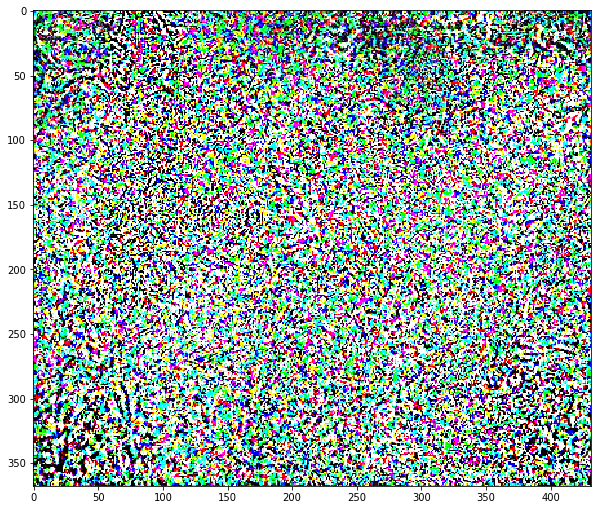

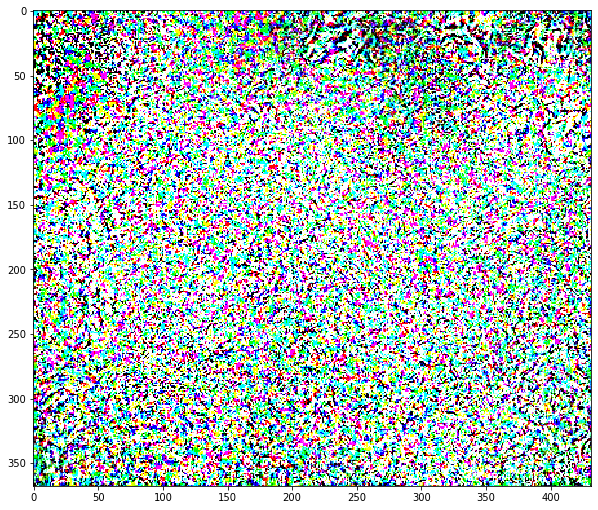

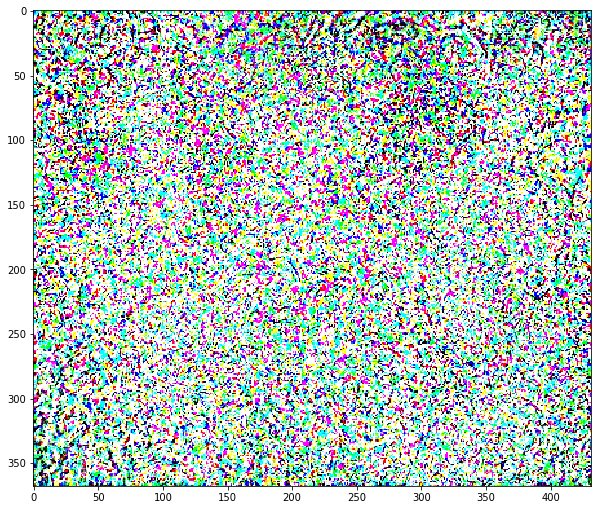

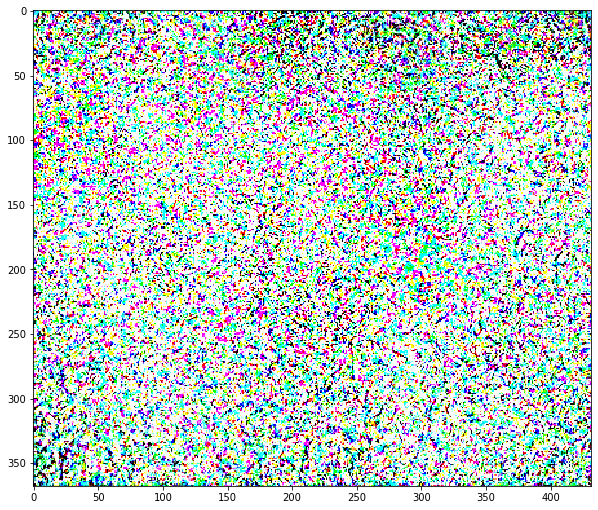

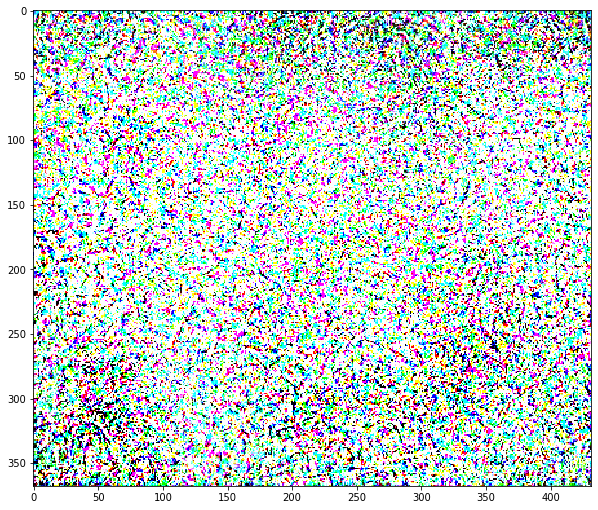

In [8]:
EPS = 5000
STEPS = 100
STAGE_INDEX = 6 # range from 2 to 6
BATCH_SIZE = 16
batch_index = 0 # where does the current batch start
image_index = 0
if not "univeral_noise" in vars():
    univeral_noise = np.zeros(image_target.shape)

target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
grad_func, loss_func = multi_stage_loss(target_heat, target_paf, STAGE_INDEX)

for i in tqdm(range(STEPS)):
    # load a batch 
    batch, batch_index = load_batch(training_paths, batch_index, BATCH_SIZE)
    gradient = np.zeros(image_target.shape)
    target_heat_batch = target_np[:, :, :, :19]
    target_paf_batch = target_np[:, :, :, 19:]
    for image in batch:
        # create the write shape of noise
        # repeated_noise = np.repeat(np.expand_dims(univeral_noise, axis=0), BATCH_SIZE, 0)
        image_with_noise = [image + univeral_noise]
        
        # compute gradient
        cur_gradient, gn_summ = estimator.persistent_sess.run(
                    [grad_func, loss_func],
                    feed_dict={
                        target_heat: target_heat_batch,
                        target_paf: target_paf_batch,
                        estimator.tensor_image: image_with_noise,
                        estimator.upsample_size: upsample_size
                    }
                )
        gradient += cur_gradient[0]
        summary_writer.add_summary(gn_summ, image_index)
        image_index += 1
    gradient /= BATCH_SIZE
    
    #
    if i % 2 == 0:
        # Prepare the plot
        plot_buf = gen_plot_universal_noise(univeral_noise)

        # Convert PNG buffer to TF image
        tf_image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

        # Add the batch dimension
        tf_image = tf.expand_dims(tf_image, 0)

        # Add image summary
        summary_op = tf.summary.image(f"universal_noise_step{i}", tf_image)
        summary_img = estimator.persistent_sess.run(summary_op)
        # Write summary
    
        summary_writer.add_summary(summary_img)
        summary_writer.flush()
    
    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    scaled_gradient =  (EPS * gradient)
    univeral_noise = univeral_noise - scaled_gradient
    univeral_noise = np.clip(univeral_noise, 0, 255)

summary_writer.flush()

In [14]:
SCALE = 10000
print(gradient.shape)
print_image_Stats(gradient[0])
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)


grad_len = np.zeros((gradient[0].shape[:2]))
for y in range(gradient[0].shape[0]):
    for x in range(gradient[0].shape[1]):
        cur_vec = gradient[0, y, x]
        grad_len[y, x] = np.linalg.norm(cur_vec)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(grad_len, cmap='hot')
fig.colorbar(heat_image, ax=ax, shrink=0.35)

2020-01-29 13:33:08,811 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)
Min: -0.008037817664444447
Max: 0.010060334578156471
Avg: 1.3104500595773061e-08


In [16]:
plot_pose(image_source, human_adv, e_source.heatMat)

2020-01-29 13:33:25,818 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


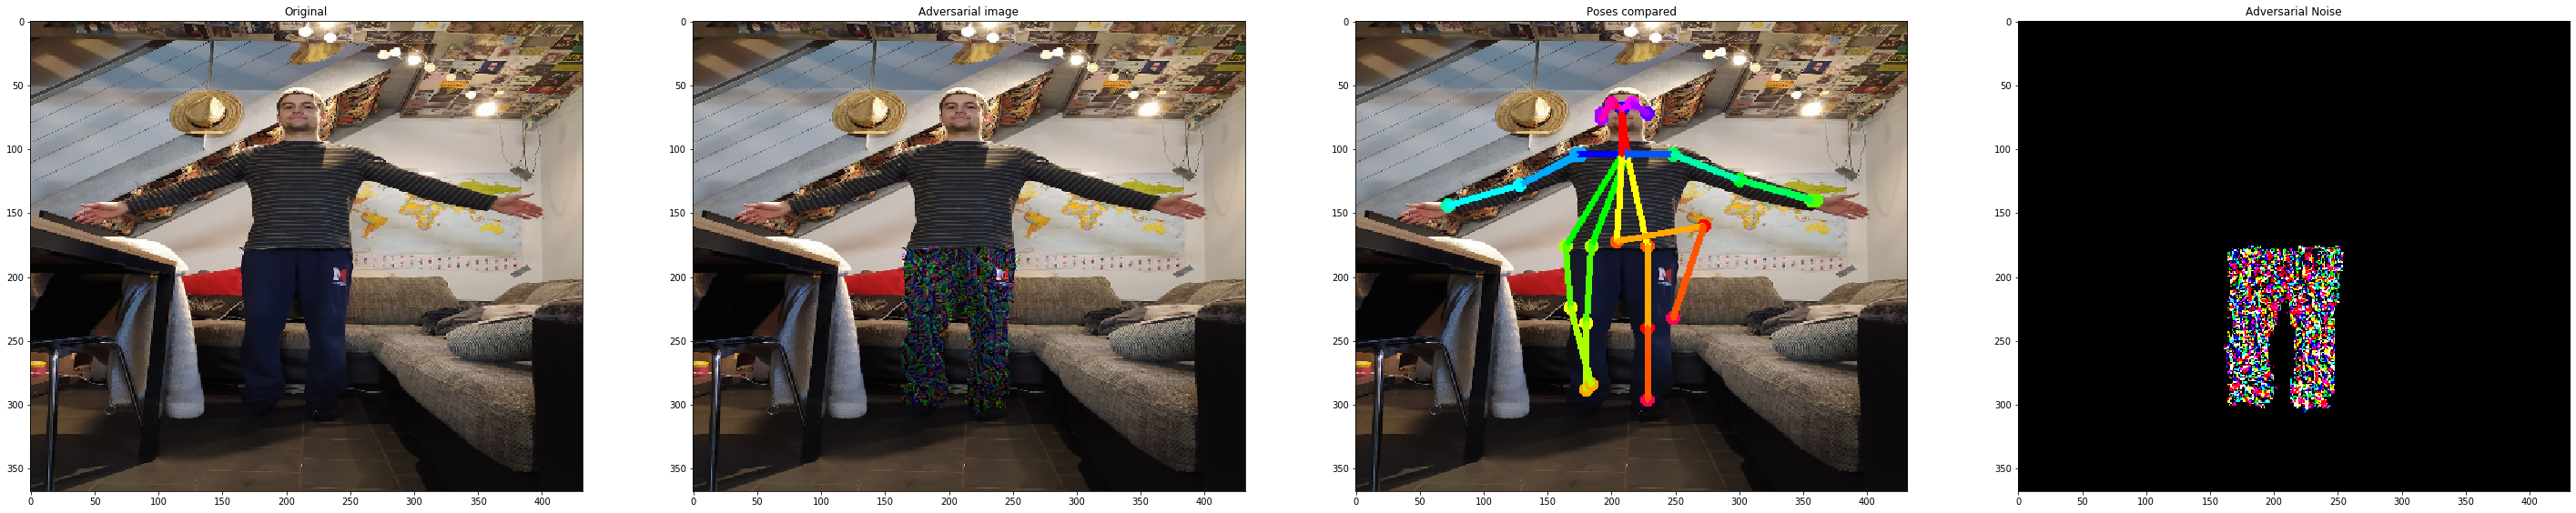

In [17]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 4, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 4, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 4, 4)
ax.set_title('Adversarial Noise')
noise = image_source - adv_image
ax.imshow(noise)

39.51681


Text(0.5, 1.0, 'Difference')

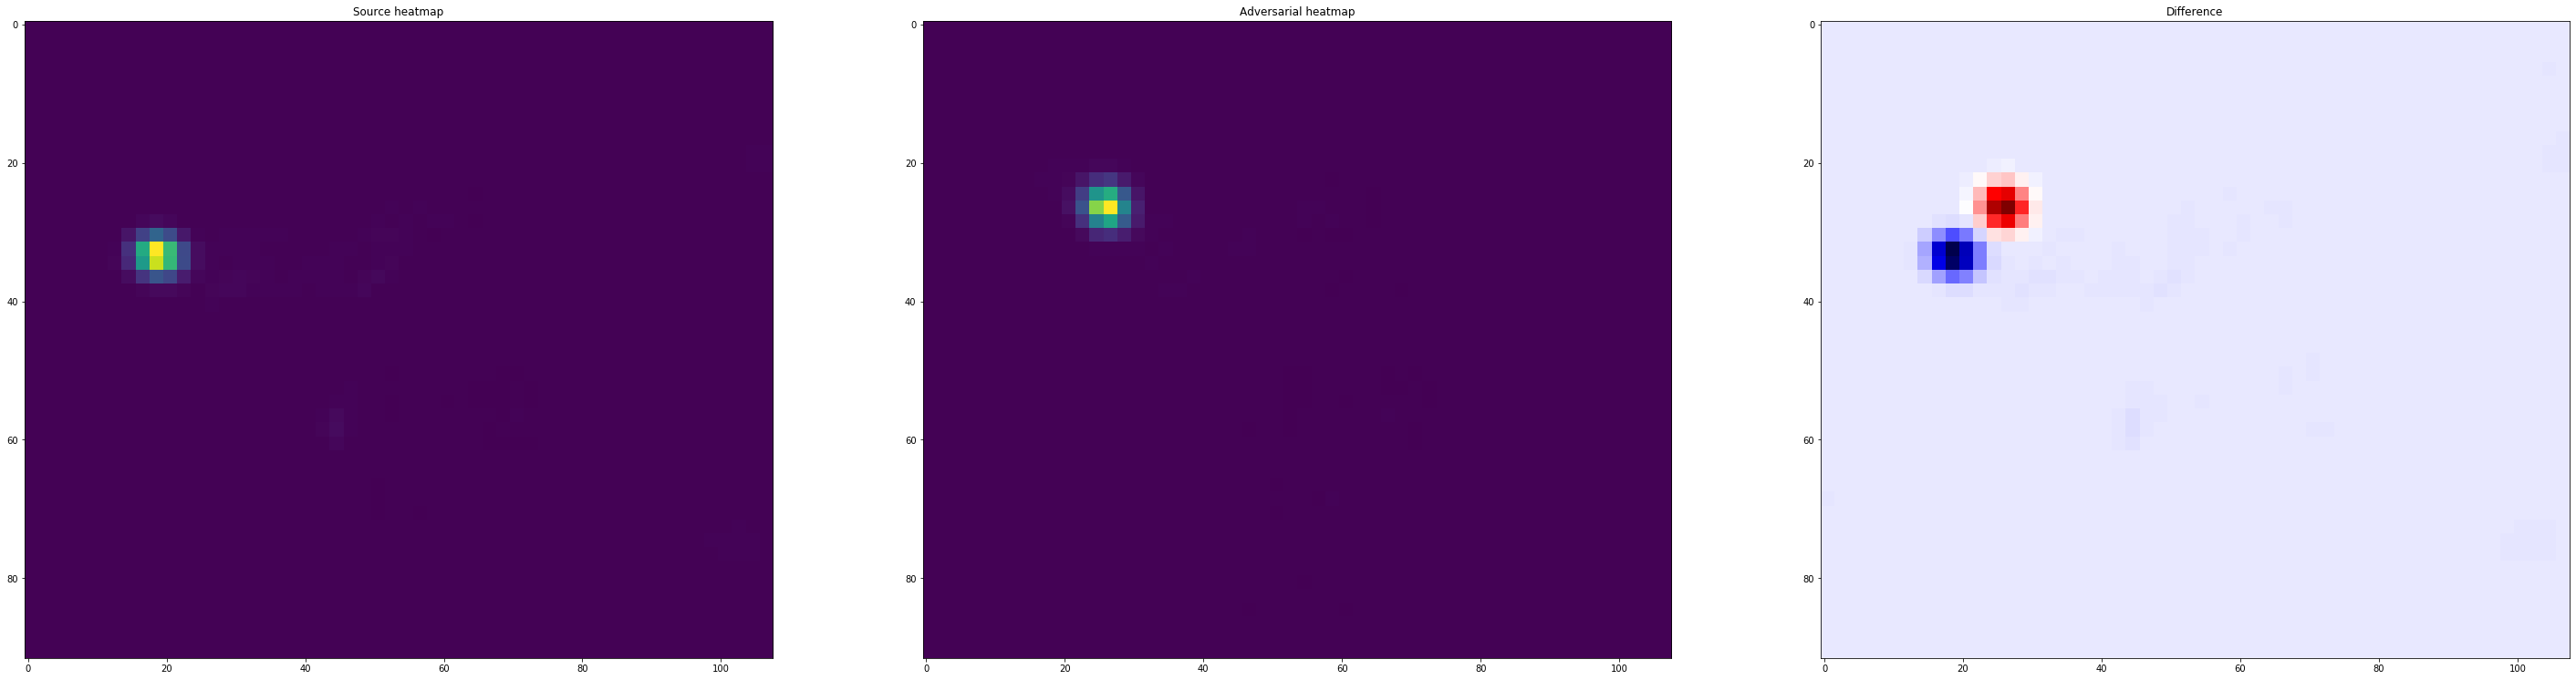

In [20]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source heatmap')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
ax.set_title('Adversarial heatmap')

print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
ax.set_title('Difference')

In [20]:
def compute_peaks(tensor_heat_placeholder):
    tensor_heatMat_up = tf.image.resize_area(tensor_heat_placeholder, upsample_size,
                                                          align_corners=False, name='upsample_heatmat')

    smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
    gaussian_heatMat = smoother.get_output()

    max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
    tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
    tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
    e_source.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e_source.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )
    return tensor_peaks




tensor_heat_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
tensor_peaks = compute_peaks(tensor_heat_placeholder)

# run for adversarial imape 
[adv_np_peaks] = e_source.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heat_placeholder: np.expand_dims(e_source.heatMat, axis=0)
            }
        )

In [21]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_peaks[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source peaks', fontdict = {'fontsize' : 40})

ax = fig.add_subplot(1, 3, 2)
ax.imshow(adv_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Adversarial peaks', fontdict = {'fontsize' : 40})

print(f'Over all difference {is_same_image(adv_np_peaks[0, : ,:, CocoPart.RWrist.value], source_np_peaks[0, :, :, CocoPart.RWrist.value])}')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(target_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Target peaks', fontdict = {'fontsize' : 40})

print(f'Localation of the peak in source {np.unravel_index(source_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), source_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(adv_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), adv_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

print(f'Localation of the peak in target {np.unravel_index(target_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), target_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

Over all difference 0.1772901862859726
Localation of the peak in source (33, 19)
Localation of the peak in adv (26, 26)
Localation of the peak in target (26, 26)


In [35]:
from deepexplain.tf.v1_x import DeepExplain

with DeepExplain(session=e_source.persistent_sess, graph=e_source.graph) as de:
        
        input_tensor = e_source.tensor_image
        output_tensor = e_source.tensor_heatMat[:, :, :, CocoPart.RWrist.value]
        xs = tf.expand_dims(image_source, 0).eval(session=e_source.persistent_sess)
        xs = xs.astype('float64')
       
        Y_shape=[None] + [1, 46, 54] # size of heatmaps
        
        #ys = np.expand_dims(np.expand_dims(current_stats["mask"], axis=0), axis=0)
        
        baseline = np.zeros(list(xs.shape)[1:]) # baseline to compare against
        saliency = de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape)
        gradInput = de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs,  Y_shape=Y_shape)

/home/ax/master/2019_02/masterThesis/DeepExplain/deepexplain/tf/v1_x/main.py:94: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


2020-01-24 16:51:53,348 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-01-24 16:51:53,367 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


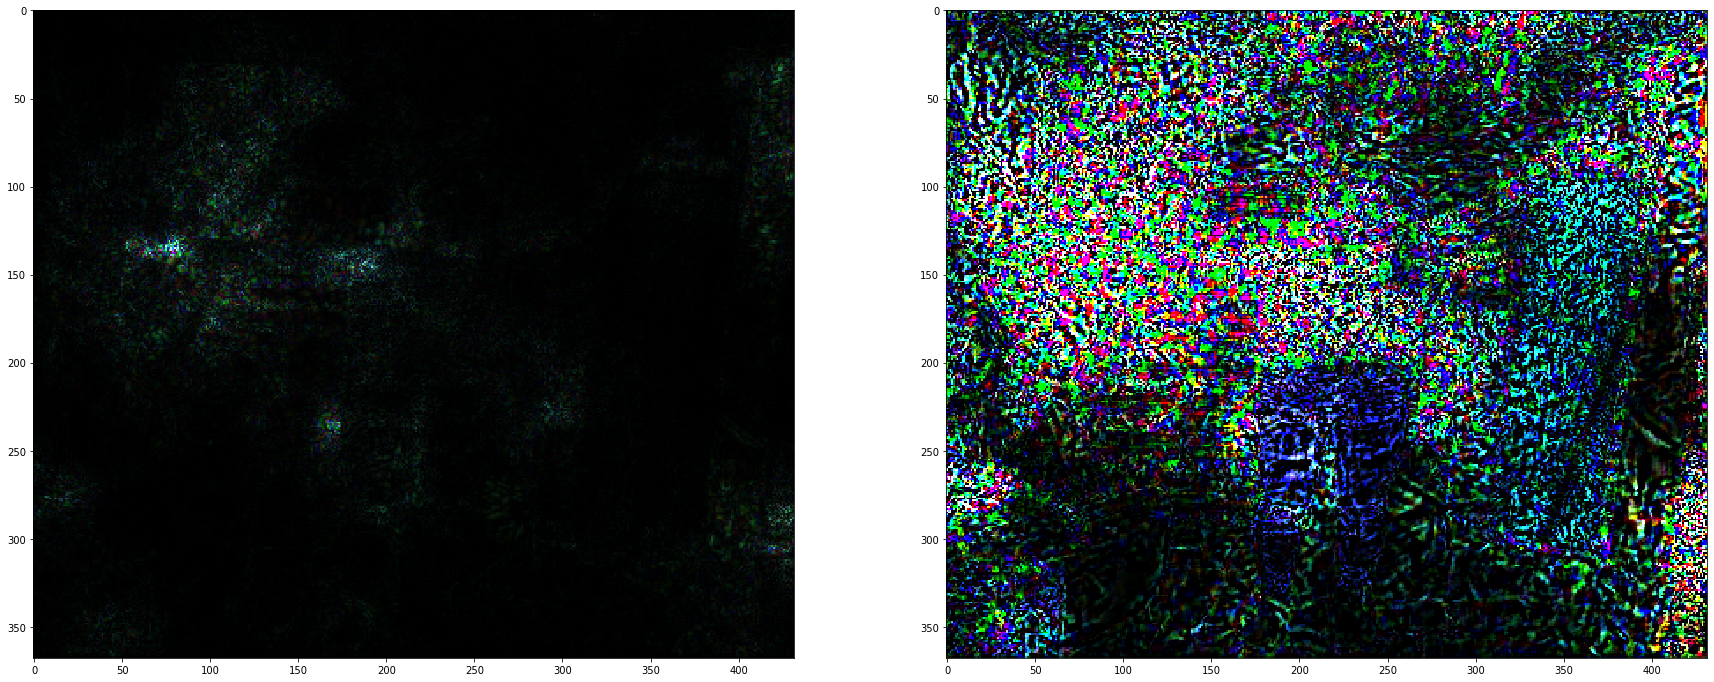

In [36]:
SCALE = 1000
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(saliency[0] * SCALE)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(gradInput[0] * SCALE, cmap='hot')